## Graph representation learning with node2vec

### 1. 商業需求、概念
透過graph概念將現有資料轉換成graph之後，透過一些traverse方式(如 random walk) 產生序列，其性質就會自然包括了graph的結構，是現在許多資料產生更多豐富語意的方法之一。


Author: Aaron, 2022/8/7

此專案是要將影片資料轉換成graph，並產生出movie embedding進而去用在推薦系統或者搜尋上。

步驟如下
1. 透過random walk產生電影序列
2. 將電影序列產生標籤(正、負)
3. 透過word2vec概念，使用電影序列產生node2vec embedding

In [1]:
# 用來建立graph的套件
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### 2. 資料準備、取得

In [3]:
# 下載檔案到local drive並解壓縮
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

In [4]:
# 將需要的放入pandas df內

movies = pd.read_csv('ml-latest-small/movies.csv')
movies['movieId'] = movies['movieId'].apply(lambda x: f"movie_{x}")

ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings['rating'] = ratings['rating'].apply(lambda x: float(x))
ratings['movieId'] = ratings['movieId'].apply(lambda x: f"movie_{x}")

print("電影資料 shape: ", movies.shape)
print("電影評論資料 shape: ", ratings.shape)

電影資料 shape:  (9742, 3)
電影評論資料 shape:  (100836, 4)


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [6]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


建立輔助函式幫助取得 movieId對應的名稱

In [7]:
def get_movie_title_by_id(movie_id):
    return list(movies[movies['movieId'] == movie_id].title)[0]

def get_movie_id_by_title(title):
    return list(movies[movies['title'] == title]['movieId'])[0]

#### 建立電影的Graph檔案

Graph的基礎為node+edge，node是電影本身，而edge則是電影之間的連結。在此我們使用pointwise mutual information去衡量電影之間的關聯性，來當作edge的權重。

PMI = log(xy)-log(x)-log(y)+log(D)

#### 步驟1: 建立 weighted edges between movies

In [8]:
min_rating = 5          # 這個假設有點粗略，每個人評分天性不一
pair_freq = defaultdict(int)
item_freq = defaultdict(int)

# 透過最低分數去篩選
rated_movies = ratings[ratings['rating'] >= min_rating]
# 透過user去group by，因為最基本單位是user
movies_grouped_by_users = list(rated_movies.groupby("userId"))
for group in tqdm(
    iterable=movies_grouped_by_users,
    position=0,
    leave=True,
    desc="建立電影評分頻率"
):
    # 目前user的評分序列
    current_movies = list(group[1]['movieId'])

    for i in range(len(current_movies)):
        # 電影頻率計算
        item_freq[current_movies[i]] += 1
        for j in range(i+1, len(current_movies)):
            # 兩電影之間頻率計算，此處比大小是用string方式
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_freq[(x, y)] += 1

建立電影評分頻率: 100%|██████████| 573/573 [00:00<00:00, 1053.03it/s]


In [9]:
pair_freq

defaultdict(int,
            {('movie_47', 'movie_50'): 17,
             ('movie_101', 'movie_47'): 2,
             ('movie_151', 'movie_47'): 4,
             ('movie_157', 'movie_47'): 1,
             ('movie_163', 'movie_47'): 4,
             ('movie_216', 'movie_47'): 3,
             ('movie_231', 'movie_47'): 7,
             ('movie_260', 'movie_47'): 16,
             ('movie_333', 'movie_47'): 5,
             ('movie_362', 'movie_47'): 2,
             ('movie_457', 'movie_47'): 12,
             ('movie_47', 'movie_527'): 11,
             ('movie_47', 'movie_553'): 2,
             ('movie_47', 'movie_596'): 3,
             ('movie_47', 'movie_608'): 10,
             ('movie_47', 'movie_661'): 2,
             ('movie_47', 'movie_919'): 2,
             ('movie_47', 'movie_923'): 2,
             ('movie_47', 'movie_940'): 1,
             ('movie_47', 'movie_954'): 1,
             ('movie_1023', 'movie_47'): 1,
             ('movie_1024', 'movie_47'): 1,
             ('movie_1025', 'mo

#### step2: 建立graph 使用剛剛取得的資訊，透過nodes、edges

In [14]:
min_weight = 10     # 也是需要仔細調整的部分
D = math.log(sum(item_freq.values()))

# 建立 movies undirected graph
movies_graph = nx.Graph()

# 透過剛剛的頻率去計算 weighted edges
for pair in tqdm(
    pair_freq,
    position=0,
    leave=True,
    desc="建立movies graph with edges and nodes"
):
    x, y = pair
    xy_freq = pair_freq[pair]
    x_freq = item_freq[x]
    y_freq = item_freq[y]
    pmi = math.log(xy_freq) - math.log(x_freq) - math.log(y_freq) + D
    weight = pmi * xy_freq      # 權重計算方式

    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

建立movies graph with edges and nodes: 100%|██████████| 298586/298586 [00:00<00:00, 577671.42it/s]


建立了graph，看看其nodes、edges數量。

In [15]:
print("Nodes 數量: ", movies_graph.number_of_nodes())
print("Edges 數量: ", movies_graph.number_of_edges())

Nodes 數量:  1405
Edges 數量:  40043


以Graph結構來說，也常常會去看平均degree，也就是每一個node的連結數目，某方面代表了相關的程度，可以給出graph的大致概念、形狀。

過往讀網路經濟學有學習到相關資訊。

In [16]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("平均 Degree: ", sum(degrees) / len(degrees))

平均 Degree:  57.00071174377224


In [17]:
movies_graph.nodes

NodeView(('movie_47', 'movie_50', 'movie_151', 'movie_163', 'movie_216', 'movie_231', 'movie_260', 'movie_333', 'movie_457', 'movie_527', 'movie_596', 'movie_608', 'movie_1029', 'movie_1073', 'movie_1080', 'movie_1089', 'movie_1136', 'movie_1196', 'movie_1197', 'movie_1198', 'movie_1206', 'movie_1210', 'movie_1213', 'movie_1220', 'movie_1222', 'movie_1240', 'movie_1270', 'movie_1275', 'movie_1278', 'movie_1291', 'movie_1517', 'movie_1573', 'movie_1617', 'movie_1625', 'movie_1732', 'movie_2005', 'movie_2094', 'movie_2115', 'movie_2116', 'movie_2329', 'movie_2387', 'movie_2459', 'movie_2470', 'movie_2502', 'movie_2529', 'movie_2542', 'movie_2571', 'movie_2700', 'movie_2716', 'movie_2858', 'movie_2949', 'movie_2959', 'movie_2987', 'movie_3033', 'movie_3052', 'movie_3147', 'movie_3253', 'movie_3386', 'movie_3441', 'movie_3578', 'movie_3671', 'movie_3703', 'movie_101', 'movie_362', 'movie_553', 'movie_923', 'movie_1097', 'movie_1282', 'movie_1587', 'movie_1954', 'movie_2058', 'movie_2078', 

#### Step3: 建立Vocabulary

In [18]:
vocabulary = ['NA'] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [19]:
vocabulary_lookup

{'NA': 0,
 'movie_47': 1,
 'movie_50': 2,
 'movie_151': 3,
 'movie_163': 4,
 'movie_216': 5,
 'movie_231': 6,
 'movie_260': 7,
 'movie_333': 8,
 'movie_457': 9,
 'movie_527': 10,
 'movie_596': 11,
 'movie_608': 12,
 'movie_1029': 13,
 'movie_1073': 14,
 'movie_1080': 15,
 'movie_1089': 16,
 'movie_1136': 17,
 'movie_1196': 18,
 'movie_1197': 19,
 'movie_1198': 20,
 'movie_1206': 21,
 'movie_1210': 22,
 'movie_1213': 23,
 'movie_1220': 24,
 'movie_1222': 25,
 'movie_1240': 26,
 'movie_1270': 27,
 'movie_1275': 28,
 'movie_1278': 29,
 'movie_1291': 30,
 'movie_1517': 31,
 'movie_1573': 32,
 'movie_1617': 33,
 'movie_1625': 34,
 'movie_1732': 35,
 'movie_2005': 36,
 'movie_2094': 37,
 'movie_2115': 38,
 'movie_2116': 39,
 'movie_2329': 40,
 'movie_2387': 41,
 'movie_2459': 42,
 'movie_2470': 43,
 'movie_2502': 44,
 'movie_2529': 45,
 'movie_2542': 46,
 'movie_2571': 47,
 'movie_2700': 48,
 'movie_2716': 49,
 'movie_2858': 50,
 'movie_2949': 51,
 'movie_2959': 52,
 'movie_2987': 53,
 'movi

#### 接著透過biased random walk建立使用者行為序列。

該演算法有對鄰居以即探索的權衡，也是實際應用上需要根據業務情境調整的參數。

隨機遊走從給定node開始，並隨機選擇要移動到的相鄰node。如果edge被加權，則根據當前node與其鄰居之間的edge的權重概率地選擇鄰居。此過程重複 num_steps 以生成一系列相關節點。 num_steps也是關鍵參數。

In [22]:
# 特定node的鄰居
for e in movies_graph.neighbors("movie_2144"):
    print(e)

movie_356
movie_7293
movie_39
movie_260
movie_318
movie_441
movie_1196
movie_1197
movie_1210
movie_1380
movie_1500
movie_1777
movie_2396
movie_2571
movie_2918
movie_3301
movie_3481
movie_4308
movie_4878
movie_5991
movie_1259
movie_1270
movie_1307
movie_1394
movie_1968
movie_2028
movie_2150
movie_2248
movie_2791
movie_2795
movie_2797
movie_2804
movie_2915
movie_3072
movie_50
movie_110
movie_322
movie_555
movie_589
movie_778
movie_953
movie_1060
movie_1079
movie_1090
movie_1101
movie_1148
movie_1200
movie_1204
movie_1207
movie_1208
movie_1214
movie_1222
movie_1225
movie_1231
movie_1234
movie_1240
movie_1247
movie_1249
movie_1252
movie_1257
movie_1285
movie_1299
movie_1304
movie_1517
movie_1610
movie_1617
movie_1663
movie_1711
movie_1784
movie_1923
movie_2114
movie_2193
movie_2302
movie_2395
movie_2542
movie_2706
movie_2716
movie_2858
movie_2944
movie_2997
movie_4002
movie_104
movie_1097
movie_2000
movie_2529
movie_2683
movie_2916
movie_2948


In [28]:
def next_step(graph, previous_node, current_node, p, q):
    """
        p: 越大越容易去探索遠的node。
        q: 越大越容易去找到近的node。
    """
    neighbors = list(graph.neighbors(current_node))

    weights = []        # 取得與目前node的鄰居權重，用以選擇如何walk
    for neighbor in neighbors:
        if neighbor == previous_node:       
            weights.append(graph[current_node][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous_node):
            # The probability of visiting a local node.
            weights.append(graph[current_node][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current_node][neighbor]["weight"] / q)
    
    # 根據上面的機率去選擇下一個node。
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]     # 其實可忽略，直接用分子沒問題
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())

    for walk_iteration in range(num_walks):
        random.shuffle(nodes)   # 隨機打散選取

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random Walk iteration {walk_iteration+1} of {num_walks}"
        ):
            walk = [node]   # 起始

            while len(walk) < num_steps:
                # 找下一個node
                current_node = walk[-1]
                previous_node = walk[-2] if len(walk) >= 2 else None
                
                next = next_step(graph, previous_node, current_node, p, q)
                walk.append(next)
            # 轉換成index
            walk = [vocabulary_lookup[token] for token in walk]
            walks.append(walk)
    
    return walks

#### 實際執行 random walk

In [29]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random Walk iteration 5 of 5: 100%|██████████| 1405/1405 [00:06<00:00, 231.30it/s]

Number of walks generated: 7025


#### 產生資料標籤

透過skip-gram方式直接產生負樣本。

In [50]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            # 電影、上下文電影
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:11<00:00, 596.67it/s]


In [51]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (881878,)
Contexts shape: (881878,)
Labels shape: (881878,)
Weights shape: (881878,)


#### 轉換的 td.data.Dataset 物件

In [52]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

### 3. 建模



In [53]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

In [54]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [55]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

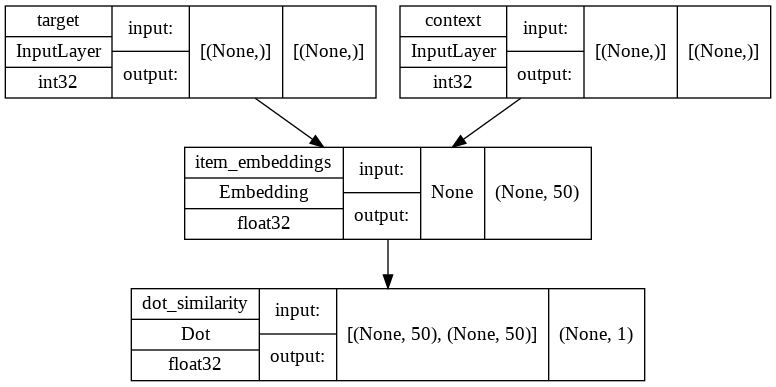

In [56]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [57]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
861/861 [==============================] - 7s 5ms/step - loss: 2.4514
Epoch 2/10
861/861 [==============================] - 3s 4ms/step - loss: 2.3401
Epoch 3/10
861/861 [==============================] - 3s 4ms/step - loss: 2.3308
Epoch 4/10
861/861 [==============================] - 3s 4ms/step - loss: 2.3254
Epoch 5/10
861/861 [==============================] - 4s 4ms/step - loss: 2.3207
Epoch 6/10
861/861 [==============================] - 4s 5ms/step - loss: 2.3166
Epoch 7/10
861/861 [==============================] - 3s 4ms/step - loss: 2.3132
Epoch 8/10
861/861 [==============================] - 3s 4ms/step - loss: 2.3101
Epoch 9/10
861/861 [==============================] - 5s 6ms/step - loss: 2.3074
Epoch 10/10
861/861 [==============================] - 4s 5ms/step - loss: 2.3046


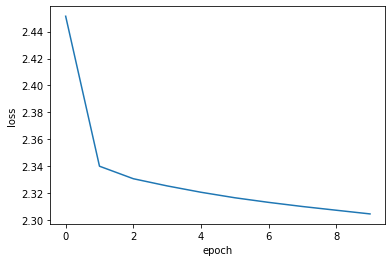

In [58]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

### 4. 視覺化 embeddings

In [59]:
# 取得 embedding
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 50)


In [60]:
# 建立一些電影當作搜尋

query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

In [61]:
# 取得其movie的embedding

query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [62]:
# 取得目標movie最相關的top k個movie，其實就相當於是推薦，透過similarity
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [63]:
# 呈現結果

for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Matrix, The (1999)
------------------
- Matrix, The (1999)
- Lord of the Rings: The Fellowship of the Ring, The (2001)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Star Wars: Episode IV - A New Hope (1977)
- Memento (2000)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Star Wars: Episode IV - A New Hope (1977)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Saving Private Ryan (1998)
- Monty Python and the Holy Grail (1975)
- Schindler's List (1993)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Apollo 13 (1995)
- Aladdin (1992)
- Independence Day (a.k.a. ID4) (1996)
- Fugitive, The (1993)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Lion King, The (1994)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Star Wars: Episode IV - A New Hope (1977)
- Saving Pri

視覺化embedding，使用[embedding projector](https://projector.tensorflow.org/)

In [64]:
import io

out_v = io.open("embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for idx, movie_id in enumerate(vocabulary[1:]):
    movie_title = list(movies[movies.movieId == movie_id].title)[0]
    vector = movie_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(movie_title + "\n")

out_v.close()
out_m.close()

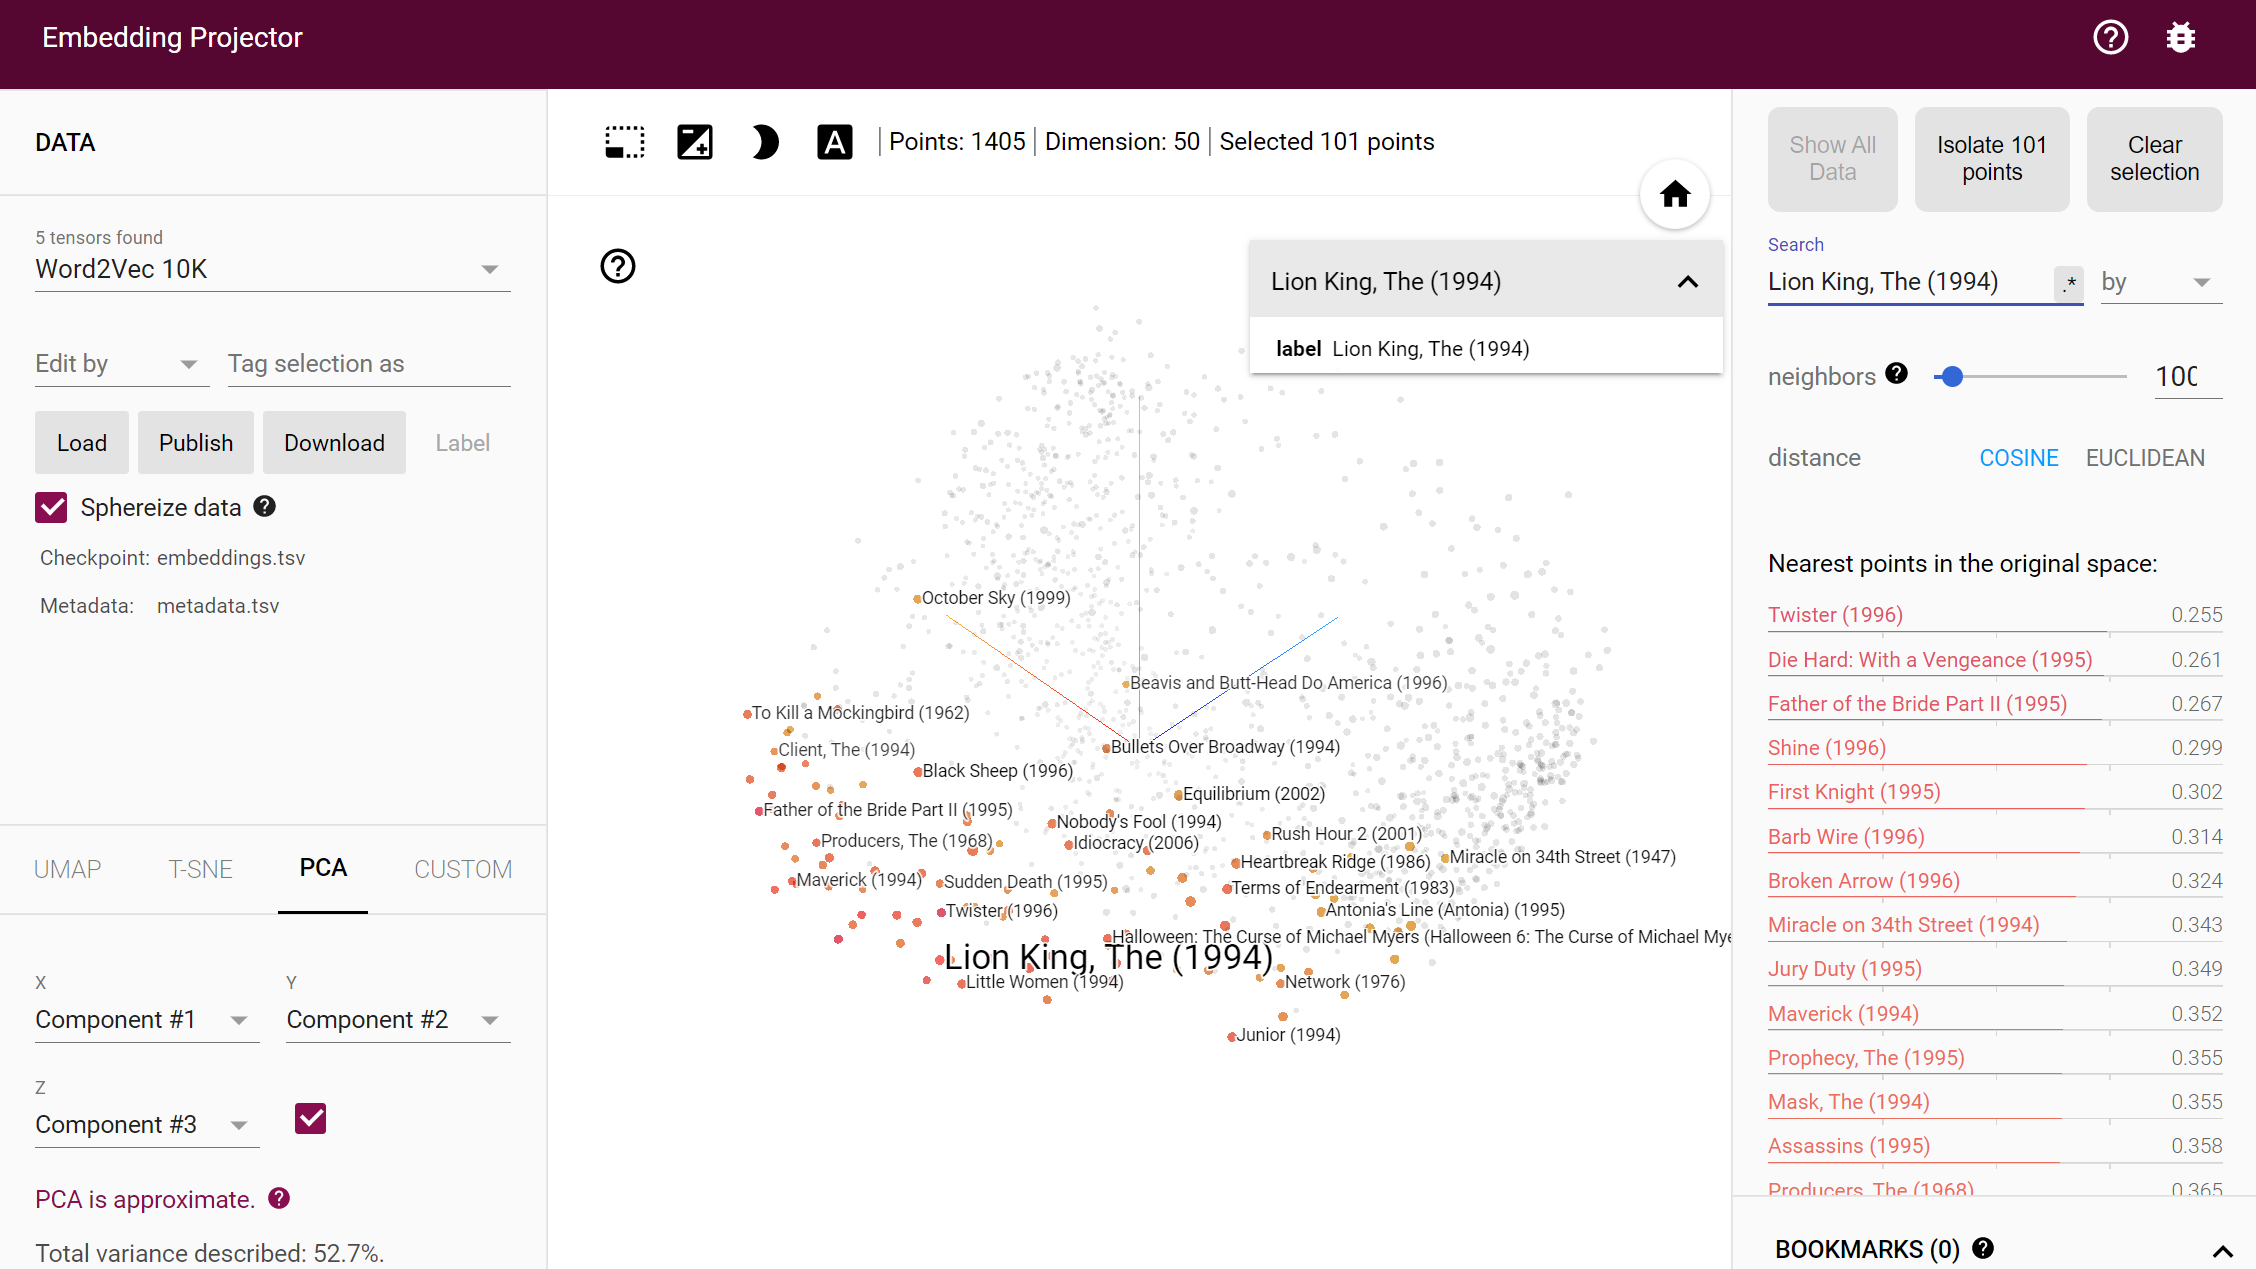

In [67]:
movie_embeddings.shape

(1406, 50)

其實可以發現這只建立了部分 movie 的 embedding，因為這是在最開始建立graph時就被剔除了，所以此方法對於冷啟動還需要進一步的開發。